# Download and preprocess SVHN dataset

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf
from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
%matplotlib inline

## Download and extract data

"SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting". It contains over 600,000 digit images and was obtained from house numbers in Google Street View images. 

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download."""
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
        last_percent_reported = percent
        
def maybe_download(filename, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    return filename

train_filename = maybe_download('train.tar.gz')
test_filename = maybe_download('test.tar.gz')
extra_filename = maybe_download('extra.tar.gz')

In [3]:
np.random.seed(150)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = root
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)
extra_folders = maybe_extract(extra_filename)

train already present - Skipping extraction of train.tar.gz.
train
test already present - Skipping extraction of test.tar.gz.
test
extra already present - Skipping extraction of extra.tar.gz.
extra


## Reading and parsing the SVHN data

We need to read the .mat file in order to determine the labels of the images and the bounding boxes around the digits

In [5]:
import h5py

# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    # getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    # getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

    # getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]
        #return [self.getDigitStructure(i) for i in range(100)]

# Return a restructured version of the dataset (one structure by boxed digit).
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

The following blocks may take a while to execute...

In [6]:
train_folders = 'train'
test_folders = 'test'
extra_folders = 'extra'

fin = os.path.join(train_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
train_data = dsf.getAllDigitStructure_ByDigit()

print('Train ready')

fin = os.path.join(test_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
test_data = dsf.getAllDigitStructure_ByDigit()

print('Test ready')

fin = os.path.join(extra_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
extra_data = dsf.getAllDigitStructure_ByDigit()

print('Extra ready')

Train ready
Test ready
Extra ready


We can save this data in order to avoid running these blocks again. We will need this files when generating the training dataset for our Regression Model .

In [7]:
pickle_file = 'SVHN_data/temp_train.pickle'

try:
    f = open(pickle_file, 'wb')
    pickle.dump(train_data, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
pickle_file = 'SVHN_data/temp_test.pickle'

try:
    f = open(pickle_file, 'wb')
    pickle.dump(test_data, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
pickle_file = 'SVHN_data/temp_extra.pickle'

try:
    f = open(pickle_file, 'wb')
    pickle.dump(extra_data, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

If we had already executed the previous blocks before, we should be able to load the files and spare some time.

In [8]:
train_folders = 'train'
test_folders = 'test'
extra_folders = 'extra'

pickle_name = 'SVHN_data/temp_train.pickle'

with open(pickle_name, 'rb') as f:
    train_data = pickle.load(f)
    
pickle_name = 'SVHN_data/temp_test.pickle'

with open(pickle_name, 'rb') as f:
    test_data = pickle.load(f)
    
pickle_name = 'SVHN_data/temp_extra.pickle'

with open(pickle_name, 'rb') as f:
    extra_data = pickle.load(f)

## CIFAR dataset

SVHN does not contain samples without numbers, I will include some CIFAR samples in the training datasets in order to show this kind of examples.

In [10]:
# DOWNLOADS AND EXTRACTS CIFAR DATASET

from six.moves import urllib
DATA_URL = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
def maybe_download_and_extract():
    """Download and extract the tarball from Alex's website."""
    dest_directory = 'CIFAR_data/'
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' % (filename,
                                                             float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)
        
maybe_download_and_extract()

filenames = [os.path.join('CIFAR_data/cifar-10-batches-py/', 'data_batch_%d' % i)for i in xrange(1, 6)]
first = True
for pickle_name in filenames:
    with open(pickle_name, 'rb') as f:
        dict_cifar10 = pickle.load(f)
        temp = dict_cifar10['data']
        if(first):
            cifar_data = temp
            first = False
        else:
            cifar_data = np.concatenate((cifar_data,temp),axis=0)

cifar_data = np.reshape(cifar_data,(-1,3,32,32))
cifar_data = np.swapaxes(cifar_data, 1, 2)
cifar_data = np.swapaxes(cifar_data, 2, 3)
print(cifar_data.shape)

(50000, 32, 32, 3)


In [11]:
# GENERATING TRAINING SAMPLES USING THE CIFAR IMAGES
import PIL.Image as Image
SIZE_CROP = 64
def generate_dataset_CIFAR(data):
    dataset = np.ndarray([data.shape[0],SIZE_CROP,SIZE_CROP,3], dtype=np.int8)
    labels = np.ones([data.shape[0],6], dtype=np.int8) * 10

    for i in np.arange(data.shape[0]):
        im = Image.fromarray(data[i])
        temp_label = [10] * 6
        temp_label[0] = 0

        im = im.resize([SIZE_CROP,SIZE_CROP], Image.ANTIALIAS)
        dataset[i,:,:,:] = im
        labels[i,:] = temp_label
        
    return dataset, labels

cifar_data, cifar_data_labels = generate_dataset_CIFAR(cifar_data)
print(cifar_data.shape, cifar_data_labels.shape)

(50000, 64, 64, 3) (50000, 6)


## Exploring the dataset

This section is just for exploring and visualizing some of the dataset characteristics and to describe some of the preprocessing steps. You can skip it and go directly to the 'Dataset Generation' section.

### 1. Analyzing the dataset

Processing all the data can also take a while...

In [9]:
# Dataset size:
print('Training size:', len(train_data))
print('Testing size:',len(test_data))
print('Extra images:',len(extra_data))

Training size: 33402
Testing size: 13068
Extra images: 202353


In [9]:
from PIL import Image
import pandas as pd

train_imsize = np.ndarray([len(train_data),2])
train_numdigits = [0]*6
for i in np.arange(len(train_data)):
    filename = train_data[i]['filename']
    fullname = os.path.join(train_folders, filename)
    im = Image.open(fullname)
    train_imsize[i, :] = im.size[:]
    
    boxes = train_data[i]['boxes']
    num_digit = len(boxes)
    if num_digit>5:
        train_numdigits[5] += 1
    else:
        train_numdigits[num_digit-1] += 1

In [10]:
test_imsize = np.ndarray([len(test_data),2])
test_numdigits = [0]*6
for i in np.arange(len(test_data)):
    filename = test_data[i]['filename']
    fullname = os.path.join(test_folders, filename)
    im = Image.open(fullname)
    test_imsize[i, :] = im.size[:]
    
    boxes = test_data[i]['boxes']
    num_digit = len(boxes)
    if num_digit>5:
        test_numdigits[5] += 1
    else:
        test_numdigits[num_digit-1] += 1

In [11]:
extra_imsize = np.ndarray([len(extra_data),2])
extra_numdigits = [0]*6
for i in np.arange(len(extra_data)):
    filename = extra_data[i]['filename']
    fullname = os.path.join(extra_folders, filename)
    im = Image.open(fullname)
    extra_imsize[i, :] = im.size[:]
    
    boxes = extra_data[i]['boxes']
    num_digit = len(boxes)
    if num_digit>5:
        extra_numdigits[5] += 1
    else:
        extra_numdigits[num_digit-1] += 1

Some basic statistics regarding the size of the different dataset images

In [12]:
d = {'Max. Height' : pd.Series([np.amax(train_imsize[:,1]), np.amax(test_imsize[:,1]), np.amax(extra_imsize[:,1])], index=['Training', 'Testing', 'Extra']),
     'Min. Height' : pd.Series([np.amin(train_imsize[:,1]), np.amin(test_imsize[:,1]), np.amin(extra_imsize[:,1])], index=['Training', 'Testing', 'Extra']),
     'Avg. Height' : pd.Series([np.mean(train_imsize[:,1]), np.mean(test_imsize[:,1]), np.mean(extra_imsize[:,1])], index=['Training', 'Testing', 'Extra']),
     'Max. Width' : pd.Series([np.amax(train_imsize[:,0]), np.amax(test_imsize[:,0]), np.amax(extra_imsize[:,0])], index=['Training', 'Testing', 'Extra']),
     'Min. Width' : pd.Series([np.amin(train_imsize[:,0]), np.amin(test_imsize[:,0]), np.amin(extra_imsize[:,0])], index=['Training', 'Testing', 'Extra']),
     'Avg. Width' : pd.Series([np.mean(train_imsize[:,0]), np.mean(test_imsize[:,0]), np.mean(extra_imsize[:,0])], index=['Training', 'Testing', 'Extra'])}
df = pd.DataFrame(d)
display(df)

,Avg. Height,Avg. Width,Max. Height,Max. Width,Min. Height,Min. Width
Training,57.213011,128.284983,501.0,876.0,12.0,25.0
Testing,71.566498,172.583486,516.0,1083.0,13.0,31.0
Extra,60.800151,100.389250,415.0,668.0,13.0,22.0


Checking the distribution of the datasets. How many digits do the images contain?

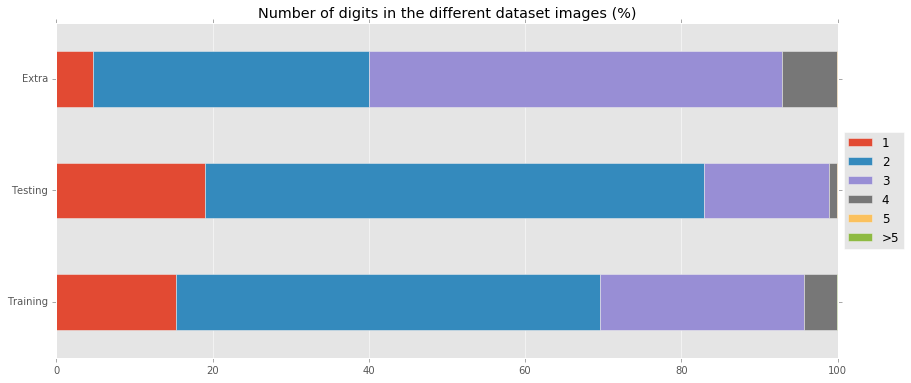

In [32]:
import matplotlib
matplotlib.style.use('ggplot')

# Computing how much % each group represents
train_numdigits_per = np.array([0, 0, 0, 0, 0, 0], dtype=float)
test_numdigits_per = np.array([0, 0, 0, 0, 0, 0], dtype=float)
extra_numdigits_per = np.array([0, 0, 0, 0, 0, 0], dtype=float)

np.true_divide(np.multiply(train_numdigits,100),np.sum(train_numdigits), train_numdigits_per)
np.true_divide(np.multiply(test_numdigits,100),np.sum(test_numdigits), test_numdigits_per)
np.true_divide(np.multiply(extra_numdigits,100),np.sum(extra_numdigits), extra_numdigits_per)

# Now add the legend with some customizations.
df2 = pd.DataFrame(np.vstack((train_numdigits_per, test_numdigits_per, extra_numdigits_per)), columns=['1', '2', '3', '4', '5', '>5'], index=['Training', 'Testing', 'Extra'])

f = plt.figure(1, figsize = (14,6))
plt.title('Number of digits in the different dataset images (%)', color='black')
df2.plot.barh(stacked=True, ax=f.gca())
axes = plt.gca()
axes.set_xlim([0,100])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### 2. Preprocessing

We will perform the same preprocessing and data augmentation described by [Goodfellow et al.](http://arxiv.org/abs/1312.6082)

#### 2.1 Finding bounding box

First, we find the smallest bounding box which would contain all individual character bounding boxes and we expand it by 30% in both the x and y direction.

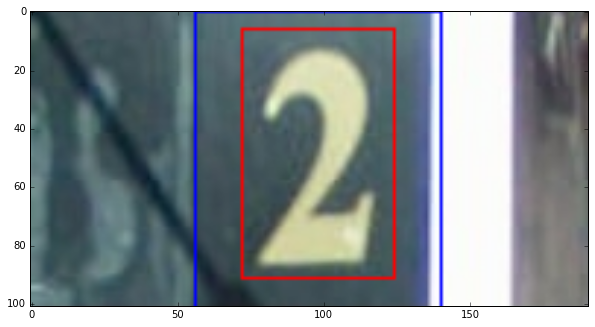

In [8]:
# Taking one picture as an example
sample_image = 20
from PIL import Image, ImageDraw
filename = train_data[sample_image]['filename']
fullname = os.path.join(train_folders, filename)
im = Image.open(fullname)

draw = ImageDraw.Draw(im)

boxes = train_data[sample_image]['boxes']
top = np.ndarray([len(boxes)], dtype='float32')
left = np.ndarray([len(boxes)], dtype='float32')
height = np.ndarray([len(boxes)], dtype='float32')
width = np.ndarray([len(boxes)], dtype='float32')
for i in range(len(boxes)):
    # Plotting individual bounding boxes in red
    draw.rectangle([boxes[i]['left'], boxes[i]['top'], boxes[i]['left']+boxes[i]['width'], boxes[i]['top']+boxes[i]['height']], fill=None, outline=(255,0,0))
    top[i] = boxes[i]['top']
    left[i] = boxes[i]['left']
    height[i] = boxes[i]['height']
    width[i] = boxes[i]['width']

im_top = np.amin(top)
im_left = np.amin(left)
im_height = np.amax(top) + height[np.argmax(top)] - im_top
im_width = np.amax(left) + width[np.argmax(left)] - im_left

# Expanding by 30%
im_bottom = np.amin([np.ceil(im_top + 1.3 * im_height), im.size[1]])
im_right = np.amin([np.ceil(im_left + 1.3 * im_width), im.size[0]])
im_top = np.amax([np.floor(im_top - 0.3 * im_height), 0])
im_left = np.amax([np.floor(im_left - 0.3 * im_width), 0])

# Plotting expanded bounding box in blue
draw.rectangle([im_left, im_top, im_right, im_bottom], fill=None, outline=(0,0,255))

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(im)
plt.grid(False)

#### 2.2 Resizing and randomly cropping

We first crop the image to the previously defined bounding box (in blue) and then resize the crop to 64x64 pixels. Then, we crop 54x54 pixel images from random locations within the 64x64 pixel window. We generate several shifted versions of each training sample, thus augmenting our data and introducing scale variability.

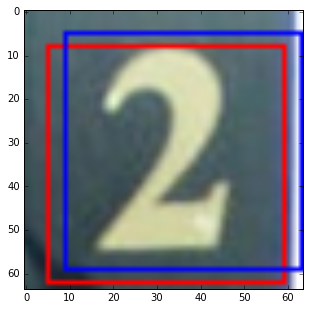

In [9]:
SIZE_CROP = 64
SIZE_FINAL = 54
filename = train_data[sample_image]['filename']
fullname = os.path.join(train_folders, filename)
im = Image.open(fullname)
im = im.crop((int(im_left), int(im_top), int(im_right), int(im_bottom))).resize([SIZE_CROP,SIZE_CROP], Image.ANTIALIAS)
draw = ImageDraw.Draw(im)

# Randomly cropping from two locations
np.random.seed(seed=1)
ran1 = np.random.randint(0, 11)
ran2 = np.random.randint(0, 11)
draw.rectangle([ran1, ran2, ran1+SIZE_FINAL, ran2+SIZE_FINAL], fill=None, outline=(255,0,0))
ran1 = np.random.randint(0, 11)
ran2 = np.random.randint(0, 11)
draw.rectangle([ran1, ran2, ran1+SIZE_FINAL, ran2+SIZE_FINAL], fill=None, outline=(0,0,255))

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(im)
plt.grid(False)

## Dataset Generation

We will now generate the different datasets. Some of the preprocessing steps described before are just for visualization. We will save the data as 64x64 pixel images and we will generate random crops directly on TensorFlow.

In [12]:
import PIL.Image as Image
SIZE_CROP = 64
def generate_dataset(data, folder):
    dataset = np.ndarray([len(data),SIZE_CROP,SIZE_CROP,3], dtype=np.int8)
    labels = np.ones([len(data),6], dtype=np.int8) * 10

    for i in np.arange(len(data)):
        filename = data[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        boxes = data[i]['boxes']
        num_digit = len(boxes)
        temp_label = [10] * 6
        temp_label[0] = num_digit
        
        # Get the individual bounding boxes
        top = np.ndarray([num_digit], dtype='float32')
        left = np.ndarray([num_digit], dtype='float32')
        height = np.ndarray([num_digit], dtype='float32')
        width = np.ndarray([num_digit], dtype='float32')
        for j in np.arange(num_digit):
            if j < 5: 
                if boxes[j]['label'] == 10:
                    temp_label[j+1] = 0
                else:
                    temp_label[j+1] = boxes[j]['label']
            else: print('#',i,'image has more than 5 digits.')
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']
        
        # Get the bounding box surrounding all digits
        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left

        # Expanding by 30%
        im_bottom = np.amin([np.ceil(im_top + 1.3 * im_height), im.size[1]])
        im_right = np.amin([np.ceil(im_left + 1.3 * im_width), im.size[0]])
        im_top = np.amax([np.floor(im_top - 0.3 * im_height), 0])
        im_left = np.amax([np.floor(im_left - 0.3 * im_width), 0])
        
        # Cropping the expanded bounding box
        im = im.crop((int(im_left), int(im_top), int(im_right), int(im_bottom))).resize([SIZE_CROP,SIZE_CROP], Image.ANTIALIAS)
        dataset[i,:,:,:] = im
        labels[i,:] = temp_label     

    return dataset, labels


train_dataset, train_labels = generate_dataset(train_data, train_folders)
print(train_dataset.shape, train_labels.shape)
del train_data

test_dataset, test_labels = generate_dataset(test_data, test_folders)
print(test_dataset.shape, test_labels.shape)
del test_data

extra_dataset, extra_labels = generate_dataset(extra_data, extra_folders)
print(extra_dataset.shape, extra_labels.shape)
del extra_data

# 29929 image has more than 5 digits.
(33402, 64, 64, 3) (33402, 6)
(13068, 64, 64, 3) (13068, 6)
(202353, 64, 64, 3) (202353, 6)


There are some images with more than 5 digits. We need to remove those.

In [13]:
# This is the number obtained during the previous step "image has more than 5 digits"
to_remove = 29929

train_dataset = np.delete(train_dataset, to_remove, axis=0)
train_labels = np.delete(train_labels, to_remove, axis=0)

print(train_dataset.shape, train_labels.shape)

(33401, 64, 64, 3) (33401, 6)


### Shuffling dataset and creating homogenous training/validation sets

We want to quarantee that the training and validation sets contain a similar amount of different number string lengths.

In [14]:
import random
random.seed()

# Percentage of Training/Extra data to use for validation
validation_prop = 0.1

n_digits = 5
valid_index = []
valid_index2 = []
train_index = []
train_index2 = []

for i in np.arange(n_digits):
    idx = np.where(train_labels[:,0] == (i+1))[0]
    numel_samples = len(idx)
    valid_index.extend(idx[:int(np.floor(numel_samples*validation_prop))].tolist())
    train_index.extend(idx[int(np.floor(numel_samples*validation_prop)):].tolist())
    
    idx = np.where(extra_labels[:,0] == (i+1))[0]
    numel_samples = len(idx)
    valid_index2.extend(idx[:int(np.floor(numel_samples*validation_prop))].tolist())
    train_index2.extend(idx[int(np.floor(numel_samples*validation_prop)):].tolist())

# Shuffling the data
random.shuffle(valid_index)
random.shuffle(train_index)
random.shuffle(valid_index2)
random.shuffle(train_index2)

valid_dataset = np.concatenate((extra_dataset[valid_index2,:,:,:], train_dataset[valid_index,:,:,:]), axis=0)
valid_labels = np.concatenate((extra_labels[valid_index2,:], train_labels[valid_index,:]), axis=0)
train_dataset_t = np.concatenate((extra_dataset[train_index2,:,:,:], train_dataset[train_index,:,:,:]), axis=0)
train_labels_t = np.concatenate((extra_labels[train_index2,:], train_labels[train_index,:]), axis=0)

#del train_dataset, train_labels, valid_index, valid_index2, train_index, train_index2
print(train_dataset_t.shape, train_labels_t.shape)
print(valid_dataset.shape, valid_labels.shape)

(212184, 64, 64, 3) (212184, 6)
(23570, 64, 64, 3) (23570, 6)


We will include some CIFAR samples into training, testing and validation datasets.

In [15]:
# Including CIFAR dataset (with no numbers in them) into train/validation/testing datasets
valid_dataset = np.concatenate((valid_dataset, cifar_data[:2000,:,:,:]), axis=0)
valid_labels = np.concatenate((valid_labels, cifar_data_labels[:2000,:]), axis=0)
test_dataset = np.concatenate((test_dataset, cifar_data[2000:5000,:,:,:]), axis=0)
test_labels = np.concatenate((test_labels, cifar_data_labels[2000:5000,:]), axis=0)

print(valid_dataset.shape, valid_labels.shape)
print(test_dataset.shape, test_labels.shape)

(25570, 64, 64, 3) (25570, 6)
(16068, 64, 64, 3) (16068, 6)


## Saving data

To avoid loading all our data into memory, we will ask TensorFlow to read from files. I am using binary files to save some space on disk.

In [18]:
# We will store the images as 1D-arrays and we will concatenate the labels at the beginning of the arrays

# Create folder where the data will be located
if not os.path.exists('SVHN_data/'):
    os.makedirs('SVHN_data/')

name = 'Train'
# Training dataset
temp = np.reshape(train_dataset_t,(train_dataset_t.shape[0],train_dataset_t.shape[1]*train_dataset_t.shape[2]*train_dataset_t.shape[3]))
temp = np.concatenate((train_labels_t,temp), axis=1)

# Splitting the data into different files in order to gain some parallelism when loading samples
num_files = 3
number_per_file = temp.shape[0] // num_files
for i in range(num_files):
    if i==num_files-1:
        segment = temp[i*number_per_file:,:]
    else:
        segment = temp[i*number_per_file:(i+1)*number_per_file,:]
    
    filename = 'SVHN_data/' + name + str(i+1) + '_' + str(SIZE_CROP)+'.bin'
    contents = segment.tobytes()
    open(filename, "wb").write(contents)

del temp

# Saving CIFAR samples. We do not have to shuffle here, we will do it when loading the data into tensorflow
cifar_data_train = cifar_data[5000:,:,:,:]
cifar_data_labels_train = cifar_data_labels[5000:,:,:,:]
temp = np.reshape(cifar_data_train,(cifar_data_train.shape[0],cifar_data_train.shape[1]*cifar_data_train.shape[2]*cifar_data_train.shape[3]))
temp = np.concatenate((cifar_data_labels_train,temp), axis=1)

filename = 'SVHN_data/' + name + str(num_files+1) + '_' + str(SIZE_CROP)+'.bin'
contents = temp.tobytes()
open(filename, "wb").write(contents)

del temp

Saving testing and validation as pickle files

In [19]:
pickle_file = 'SVHN_data/SVHN64.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 511897885
